In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Lab 9 - Multi-layer Perceptron Forward Pass & Backpropagation

## Part I
For this exercise you will implement a simple 2-layer perceptron with the forward pass and the backpropagation to learn the weights

For the first part you'll build and train a 2-layer neural network that predicts the prices of houses, using the usual Boston housing dataset.

In [2]:
boston = pd.read_csv('BostonHousing.txt')

As usual, consider the MEDV as your target variable. 
* Split the data into training, validation and testing (70,15,15)%
* Experiment with different number of neurons per layer for your network, using the validation set

In [3]:
# your code goes here

from sklearn.model_selection import train_test_split

# Separando os dados dos targets
y = boston["medv"]
X = boston.drop("medv", axis = 1)

# Separando os dados
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X, y, test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size = 3/17)

# Convertendo para arrays
X_train_and_val, X_test, y_train_and_val, y_test = X_train_and_val.to_numpy(), X_test.to_numpy(), y_train_and_val.to_numpy(), y_test.to_numpy()
X_train, X_val, y_train, y_val = X_train.to_numpy(), X_val.to_numpy(), y_train.to_numpy(), y_val.to_numpy()

In [4]:
# your code goes here

# Função da ativação sigmoidal
def sigmoid_activation(z):
    # Calculando o valor da sigmoide
    return 1/(1 + np.exp(-z))

# Função da derivada da sigmoide
def sigmoid_derivative(z):
    # Calculando o valor da derivada
    return sigmoid_activation(z)*(1-sigmoid_activation(z))

# Função para calcular o RMSE
def rmse(y_true, y_pred):
    return np.sqrt(((y_pred - y_true)**2).mean())

# Função do forward pass para regressão
def regression_forward_pass(X, W_hidden, W_output, activation):
    # Adicionando a coluna do bias
    if np.ndim(X) == 1:
        X = np.insert(X, 0, 1)
    else:
        X = np.insert(X, 0, 1, axis = 1)

    # Calculando a camada oculta
    hidden_layer = X @ W_hidden
    activated_hidden_layer = activation(hidden_layer)

    # Inserindo novamente a camada do bias
    if np.ndim(activated_hidden_layer) == 1:
        activated_hidden_layer_bias = np.insert(activated_hidden_layer, 0, 1)
    else:
        activated_hidden_layer_bias = np.insert(activated_hidden_layer, 0, 1, axis = 1)

    # Calculando a camada de saída
    y_pred = activated_hidden_layer_bias @ W_output

    nodes_values = [hidden_layer, activated_hidden_layer_bias, y_pred]

    return nodes_values

# Função do backpropagation
def regression_backpropagation(x_input, y_true, y_pred, hidden_layer, activated_hidden_layer_bias, W_output, activation_derivative):
    # Adicionando a coluna do bias ao dado
    x_input = np.insert(x_input, 0, 1)

    # Calculando os gradientes dos pesos da última camada
    W_output_gradient = (y_pred - y_true)*activated_hidden_layer_bias

    # Calculando os gradientes dos pesos da camada oculta
    delta = (y_pred - y_true).reshape((1, -1))
    W_hidden_gradient = x_input.reshape((-1, 1)) @ (activation_derivative(hidden_layer).reshape((1, -1)) * (delta @ W_output[1:, :].T))
    
    return [W_hidden_gradient, W_output_gradient]

# Função de atualização dos pesos
def update_weights(W_hidden, W_output, W_hidden_gradient, W_output_gradient, lr):
    # Ajustando os shapes das matrizes
    W_hidden_gradient = W_hidden_gradient.reshape(W_hidden.shape)
    W_output_gradient = W_output_gradient.reshape(W_output.shape)
    # Atualizando os pesos
    W_hidden -= lr*W_hidden_gradient
    W_output -= lr*W_output_gradient

    return W_hidden, W_output

In [5]:
# ENCONTRANDO O MELHOR NÚMERO DE NÓS POR MEIO DA VALIDAÇÃO

# Listas com os erros no conjunto de validação
val_errors = []
# Número de dados
n_of_datapoints = X_train.shape[0]
# Número máximo de nós
max_nodes = 13

# Juntando as matrizes de dados e rótulos para embaralhar corretamente
data_train = np.hstack((X_train, y_train.reshape((-1, 1))))

# Para cada número de nós...
for n_of_nodes in range(1, max_nodes + 1):
    # Inicializa aleatoriamente as matrizes de pesos
    W_hidden = np.random.normal(0, 0.001, (X_train.shape[1] + 1, n_of_nodes))
    W_output = np.random.normal(0, 0.001, (n_of_nodes + 1, 1))

    # Para cada época...
    for epoch in range(10):
        # Embaralha os dados e separa de volta
        np.random.shuffle(data_train)
        shuffled_X_train = data_train[:, :-1]
        shuffled_y_train = data_train[:, -1]

        # Para cada datapoint...
        for datapoint in range(n_of_datapoints):
            # Avança na rede, calcula os gradientes e atualiza os pesos
            hidden_layer, activated_hidden_layer_bias, y_pred = regression_forward_pass(shuffled_X_train[datapoint], W_hidden, W_output, sigmoid_activation)
            W_hidden_gradient, W_output_gradient = regression_backpropagation(shuffled_X_train[datapoint], shuffled_y_train[datapoint], y_pred, hidden_layer, activated_hidden_layer_bias, W_output, sigmoid_derivative)
            W_hidden, W_output = update_weights(W_hidden, W_output, W_hidden_gradient, W_output_gradient, 0.0001)

    # Calcula o erro no conjunto de validação
    y_val_pred = regression_forward_pass(X_val, W_hidden, W_output, sigmoid_activation)[2]
    current_error = rmse(y_val, y_val_pred)
    val_errors.append(current_error)

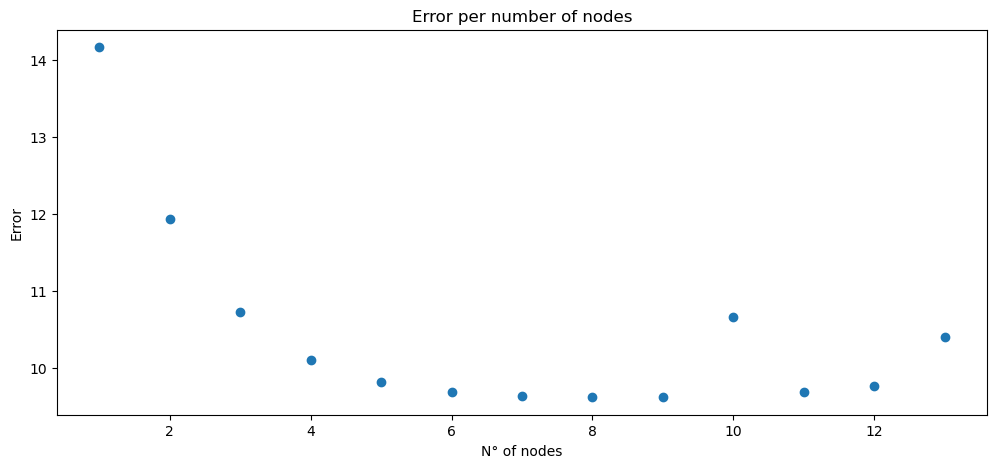

In [6]:
# Plotando o gráfico do erro por quantidade de nós
plt.figure(figsize = (12, 5))
plt.scatter(np.linspace(1, 13, 13), val_errors)
plt.title("Error per number of nodes")
plt.xlabel("N° of nodes")
plt.ylabel("Error")
plt.show()

In [7]:
# Melhor número de nós
n_of_nodes = np.argmin(val_errors) + 1
print("Best number of nodes: ", n_of_nodes)

Best number of nodes:  9


In [8]:
# TREINANDO O MODELO PARA O NÚMERO DE NÓS SELECIONADO

# Lista com os erros ao longo do aprendizado
errors = []
# Número de dados
n_of_datapoints = X_train_and_val.shape[0]

# Juntando os dados e os rótulos dos conjuntos de treino e validação para embaralhá-los
data_train_and_val = np.hstack((X_train_and_val, y_train_and_val.reshape((-1, 1))))

# Inicializando as matrizes de pesos aleatoriamente
W_hidden = np.random.normal(0, 0.01, (X_train.shape[1] + 1, n_of_nodes))
W_output = np.random.normal(0, 0.01, (n_of_nodes + 1, 1))

# Em cada época...
for epoch in range(50):
    # Embaralha os dados
    np.random.shuffle(data_train_and_val)
    # Separa de volta em dados e rótulos
    shuffled_X_train_and_val = data_train_and_val[:, :-1]
    shuffled_y_train_and_val = data_train_and_val[:, -1]

    # Para cada dado...
    for datapoint in range(n_of_datapoints):
        # Avança na rede, calcula os gradientes e atualiza os pesos
        hidden_layer, activated_hidden_layer_bias, y_pred = regression_forward_pass(shuffled_X_train_and_val[datapoint], W_hidden, W_output, sigmoid_activation)
        W_hidden_gradient, W_output_gradient = regression_backpropagation(shuffled_X_train_and_val[datapoint], shuffled_y_train_and_val[datapoint], y_pred, hidden_layer, activated_hidden_layer_bias, W_output, sigmoid_derivative)
        W_hidden, W_output = update_weights(W_hidden, W_output, W_hidden_gradient, W_output_gradient, 0.0001)

    # Calcula o erro e salva na lista
    y_train_and_val_pred = regression_forward_pass(X_train_and_val, W_hidden, W_output, sigmoid_activation)[2]
    current_error = rmse(y_train_and_val, y_train_and_val_pred)
    errors.append(current_error)

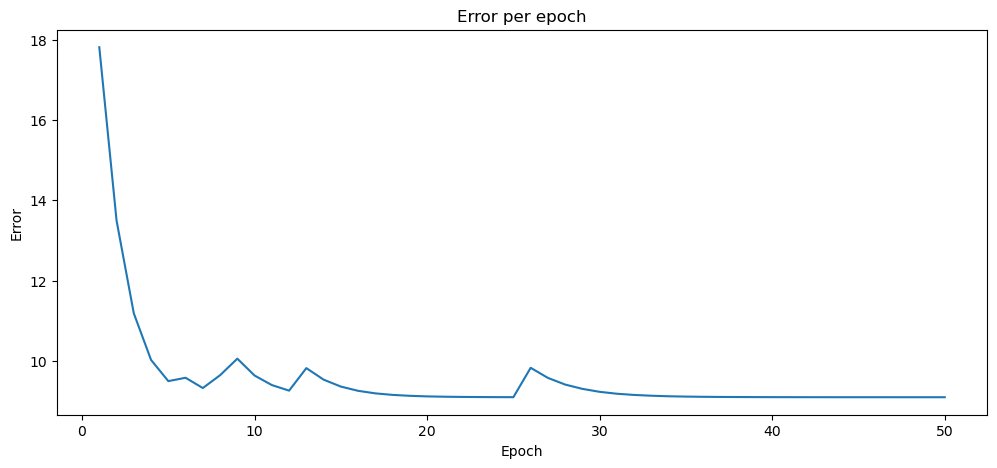

In [9]:
# Plotando o gráfico do erro por época
plt.figure(figsize = (12, 5))
plt.plot(np.linspace(1, 50, 50), errors)
plt.title("Error per epoch")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

In [10]:
# Avaliando o desempenho no conjunto de teste
y_test_pred = regression_forward_pass(X_test, W_hidden, W_output, sigmoid_activation)[2]
test_error = rmse(y_test, y_test_pred)
print("Model test error: ", test_error)

Model test error:  9.71068037337494


## Part II 

For this exercise you will build and train a 2-layer neural network that predicts the exact digit from a hand-written image, using the MNIST dataset. 
For this exercise, add weight decay to your network.

In [11]:
from sklearn.datasets import load_digits

In [12]:
digits = load_digits()

In [13]:
X = digits.data
y = digits.target

In [14]:
X.shape

(1797, 64)

Again, you will split the data into training, validation and testing.

In [15]:
# your code goes here:

# Separando os dados
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X, y, test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size = 3/17)

In [16]:
# your code goes here:

# Função da ativação softmax
def softmax_activation(z):
    # Calculando as somas dos scores de cada datapoint
    if np.ndim(z) == 1:
        column_sums = np.sum(np.exp(z))
    else:
        column_sums = np.sum(np.exp(z), axis = 1).reshape(-1, 1)
    
    # Retornando os scores normalizados
    return np.exp(z)/column_sums

# Função para calcular o erro do algoritmo de classificação multiclasse com regularização
def cross_entropy_loss(Y_pred, y_true, W_hidden, W_output, lbda):
    # Vetor para armazenar as probabilidades previstas para as classes corretas
    correct_class_predictions = np.zeros(y_true.size)

    # Para cada dado...
    for datapoint in range(y_true.size):
        # Salva no vetor a probabilidade prevista para a sua classe correta
        correct_class_predictions[datapoint] = Y_pred[datapoint, y_true[datapoint]]

    # Calcula o erro da entropia cruzada multiclasse com o weight decay
    return -np.sum(np.log(correct_class_predictions)) + (lbda/2)*(np.sum(W_hidden**2) + np.sum(W_output**2))

# Função do forward pass para classificação multiclasse
def mc_classification_forward_pass(X, W_hidden, W_output, hidden_activation, output_activation):
    # Adicionando a coluna do bias
    if np.ndim(X) == 1:
        X = np.insert(X, 0, 1)
    else:
        X = np.insert(X, 0, 1, axis = 1)

    # Calculando a camada oculta
    hidden_layer = X @ W_hidden
    activated_hidden_layer = hidden_activation(hidden_layer)

    # Inserindo novamente a camada do bias
    if np.ndim(activated_hidden_layer) == 1:
        activated_hidden_layer_bias = np.insert(activated_hidden_layer, 0, 1)
    else:
        activated_hidden_layer_bias = np.insert(activated_hidden_layer, 0, 1, axis = 1)

    # Calculando a camada de saída
    output_layer = activated_hidden_layer_bias @ W_output
    y_pred = output_activation(output_layer)

    nodes_values = [hidden_layer, activated_hidden_layer_bias, output_layer, y_pred]

    return nodes_values

# Função do backpropagation para classificação multiclasse
def mc_classification_backpropagation(x_input, y_true, output_layer, y_pred, hidden_layer, activated_hidden_layer_bias, W_output, activation_derivative, lbda):
    # Adicionando a coluna do bias ao dado
    x_input = np.insert(x_input, 0, 1)

    # Calculando os gradientes dos pesos da última camada
    W_output_gradient = activated_hidden_layer_bias.reshape((-1, 1)) @ (output_layer - y_true).reshape((1, -1)) + lbda*W_output

    # Calculando os gradientes dos pesos da camada oculta
    delta = (y_pred - y_true).reshape((1, -1))
    W_hidden_gradient = x_input.reshape((-1, 1)) @ (activation_derivative(hidden_layer).reshape((1, -1)) * (delta @ W_output[1:, :].T)) + lbda*W_hidden

    return [W_hidden_gradient, W_output_gradient]

In [24]:
# ENCONTRANDO O MELHOR NÚMERO DE NÓS POR MEIO DA VALIDAÇÃO

# Listas com os erros no conjunto de validação
val_errors = []
# Número de dados
n_of_datapoints = X_train.shape[0]

# Criando a matriz de alvo do treino
Y_train = np.zeros((n_of_datapoints, 10))
for datapoint in range(n_of_datapoints):
    Y_train[datapoint, int(y_train[datapoint])] = 1

# Número máximo de nós
max_nodes = 64

# Juntando as matrizes de dados e rótulos para embaralhar corretamente
data_train = np.hstack((X_train, Y_train))

# Para cada número de nós...
for n_of_nodes in range(1, max_nodes + 1):
    # Inicializa aleatoriamente as matrizes de pesos
    W_hidden = np.random.normal(0, 0.001, (X_train.shape[1] + 1, n_of_nodes))
    W_output = np.random.normal(0, 0.001, (n_of_nodes + 1, 10))

    # Para cada época...
    for epoch in range(10):
        # Embaralha os dados e separa de volta
        np.random.shuffle(data_train)
        shuffled_X_train = data_train[:, :-10]
        shuffled_Y_train = data_train[:, -10:]

        # Para cada datapoint...
        for datapoint in range(n_of_datapoints):
            # Avança na rede, calcula os gradientes e atualiza os pesos
            hidden_layer, activated_hidden_layer_bias, output_layer, y_pred = mc_classification_forward_pass(shuffled_X_train[datapoint], W_hidden, W_output, sigmoid_activation, softmax_activation)
            W_hidden_gradient, W_output_gradient = mc_classification_backpropagation(shuffled_X_train[datapoint], shuffled_Y_train[datapoint], output_layer, y_pred, hidden_layer, activated_hidden_layer_bias, W_output, sigmoid_derivative, 0.01)
            W_hidden, W_output = update_weights(W_hidden, W_output, W_hidden_gradient, W_output_gradient, 0.01)

    # Calcula o erro no conjunto de validação
    y_val_pred = mc_classification_forward_pass(X_val, W_hidden, W_output, sigmoid_activation, softmax_activation)[3]
    current_error = cross_entropy_loss(y_val_pred, y_val, W_hidden, W_output, 0.01)
    val_errors.append(current_error)

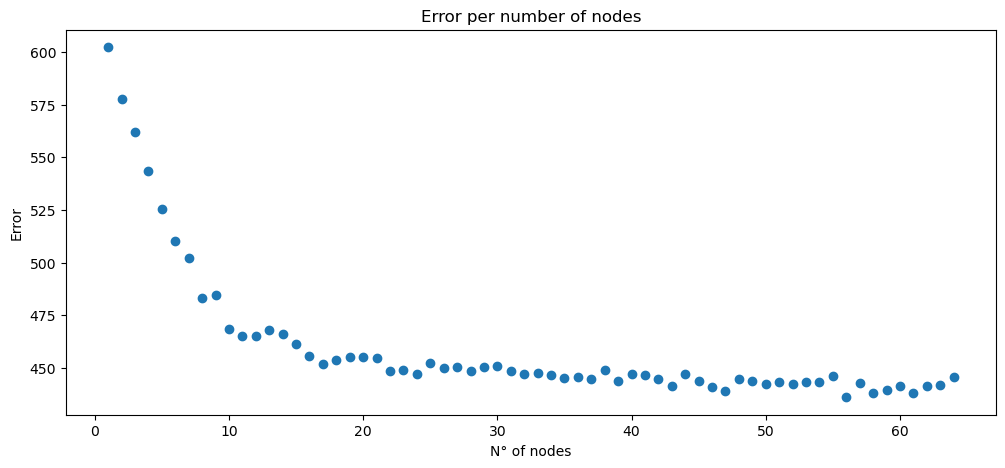

In [25]:
# Plotando o gráfico do erro por quantidade de nós
plt.figure(figsize = (12, 5))
plt.scatter(np.linspace(1, 64, 64), val_errors)
plt.title("Error per number of nodes")
plt.xlabel("N° of nodes")
plt.ylabel("Error")
plt.show()

In [26]:
# Número de nós
n_of_nodes = np.argmin(val_errors) + 1
print("Best number of nodes: ", n_of_nodes)

Best number of nodes:  56


In [27]:
# TREINANDO O MODELO PARA O NÚMERO DE NÓS SELECIONADO

# Lista com os erros ao longo do aprendizado
errors = []
# Número de dados
n_of_datapoints = X_train_and_val.shape[0]

# Criando a matriz de alvo de treino e validação
Y_train_and_val = np.zeros((n_of_datapoints, 10))
for datapoint in range(n_of_datapoints):
    Y_train_and_val[datapoint, int(y_train_and_val[datapoint])] = 1

# Juntando os dados e os rótulos dos conjuntos de treino e validação para embaralhá-los
data_train_and_val = np.hstack((X_train_and_val, Y_train_and_val))

# Inicializando as matrizes de pesos aleatoriamente
W_hidden = np.random.normal(0, 0.1, (X_train_and_val.shape[1] + 1, n_of_nodes))
W_output = np.random.normal(0, 0.1, (n_of_nodes + 1, 10))

# Para cada época...
for epoch in range(50):
    # Embaralha os dados e separa de volta
    np.random.shuffle(data_train_and_val)
    shuffled_X_train_and_val = data_train_and_val[:, :-10]
    shuffled_y_train_and_val = data_train_and_val[:, -10:]

    # Para cada datapoint...
    for datapoint in range(n_of_datapoints):
        # Avança na rede, calcula os gradientes e atualiza os pesos
        hidden_layer, activated_hidden_layer_bias, output_layer, y_pred = mc_classification_forward_pass(shuffled_X_train_and_val[datapoint], W_hidden, W_output, sigmoid_activation, softmax_activation)
        W_hidden_gradient, W_output_gradient = mc_classification_backpropagation(shuffled_X_train_and_val[datapoint], shuffled_y_train_and_val[datapoint], output_layer, y_pred, hidden_layer, activated_hidden_layer_bias, W_output, sigmoid_derivative, 0.01)
        W_hidden, W_output = update_weights(W_hidden, W_output, W_hidden_gradient, W_output_gradient, 0.01)

    # Calcula o erro no conjunto de treino
    y_test_pred = mc_classification_forward_pass(X_test, W_hidden, W_output, sigmoid_activation, softmax_activation)[3]
    current_error = cross_entropy_loss(y_test_pred, y_test, W_hidden, W_output, 0.01)
    errors.append(current_error)

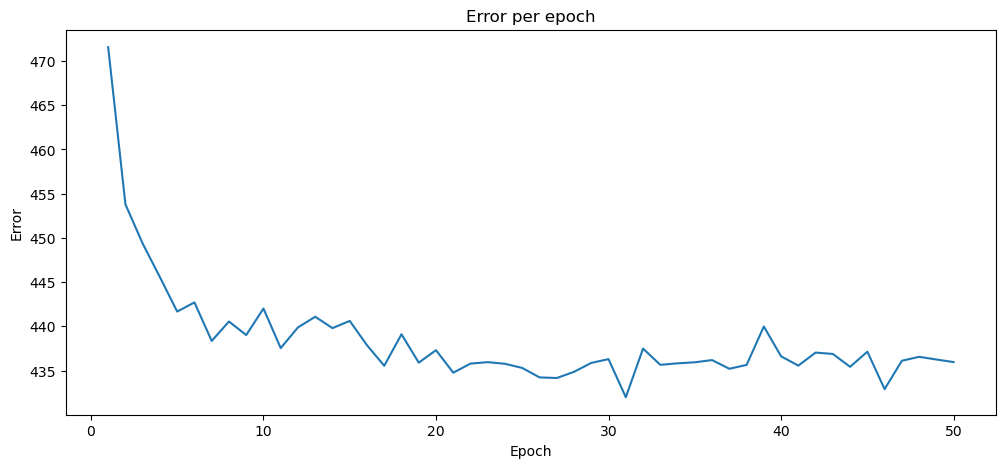

In [28]:
# Plotando o gráfico do erro por época
plt.figure(figsize = (12, 5))
plt.plot(np.linspace(1, 50, 50), errors)
plt.title("Error per epoch")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

In [29]:
# Avaliando o desempenho no conjunto de teste
y_test_pred = mc_classification_forward_pass(X_test, W_hidden, W_output, sigmoid_activation, softmax_activation)[3]
test_error = cross_entropy_loss(y_test_pred, y_test, W_hidden, W_output, 0.01)
print("Model test error: ", test_error)

Model test error:  435.96493151546


In [30]:
# Calculando a acurácia do modelo
correct_preds = np.sum(np.argmax(y_test_pred, axis = 1) == y_test)
print("Accuracy: ", correct_preds/y_test.size)

Accuracy:  0.9740740740740741
